# MLP sobre embeddings CLS (TimeSformer Frozen)

Este notebook entrena un clasificador MLP binario usando embeddings CLS precomputados de TimeSformer.
Entrada: archivos `.mmap` en `processed/`.
Salida: métricas (AUC, F1, Recall, FAR) y artefactos de resultados.


In [1]:
import json
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

PROCESSED = Path("processed")
MANIFEST_PATH = PROCESSED / "manifest_timesformer_cls.json"
assert MANIFEST_PATH.exists(), f"No existe {MANIFEST_PATH}"


DEVICE: cuda


### Paso X — Carga del *manifest* y apertura de embeddings con `memmap` (train/val/test)

Esta celda **carga el archivo `manifest.json`** del experimento y luego **abre (sin cargar a RAM)** los archivos binarios (`.bin`/`.dat`) que contienen:

- `y_train`, `y_val`, `y_test`: etiquetas (0/1) guardadas como vector 1D (`int8`).
- `X_train`, `X_val`, `X_test`: embeddings del codificador guardados como matriz 2D (`float16`) de forma `(N, D)`.

La idea central es usar **`np.memmap`** para trabajar con datasets grandes: se mapean desde disco y se leen “on demand”.


In [2]:
with open(MANIFEST_PATH, "r") as f:
    manifest = json.load(f)

print("Model:", manifest["model"])
print("T:", manifest["T"], "IMG_SIZE:", manifest["img_size"], "D:", manifest["embedding_dim"])

files = manifest["files"]

D = int(manifest["embedding_dim"])

def infer_1d_length(file_path: Path, dtype: str) -> int:
    nbytes = file_path.stat().st_size
    item = np.dtype(dtype).itemsize
    assert nbytes % item == 0, "Tamaño de archivo no calza con dtype"
    return nbytes // item

def open_y(file_path: Path, dtype="int8"):
    N = infer_1d_length(file_path, dtype)
    y = np.memmap(file_path, mode="r", dtype=dtype, shape=(N,))
    return y

def open_X(file_path: Path, N: int, D: int, dtype="float16"):
    # Validar que el tamaño calza con N*D
    nbytes = file_path.stat().st_size
    item = np.dtype(dtype).itemsize
    expected = N * D * item
    assert nbytes == expected, f"X size mismatch. got={nbytes}, expected={expected}"
    X = np.memmap(file_path, mode="r", dtype=dtype, shape=(N, D))
    return X

# Abrir y primero (para inferir N)
y_train = open_y(Path(files["y_train"]), dtype="int8")
y_val   = open_y(Path(files["y_val"]), dtype="int8")
y_test  = open_y(Path(files["y_test"]), dtype="int8")


N_train, N_val, N_test = len(y_train), len(y_val), len(y_test)
print("N_train, N_val, N_test:", N_train, N_val, N_test)

# Abrir X con shapes correctas
X_train = open_X(Path(files["X_train"]), N_train, D, dtype="float16")
X_val   = open_X(Path(files["X_val"]),   N_val,   D, dtype="float16")
X_test  = open_X(Path(files["X_test"]),  N_test,  D, dtype="float16")

print("X_train shape:", X_train.shape, "dtype:", X_train.dtype)


Model: facebook/timesformer-base-finetuned-k400
T: 8 IMG_SIZE: 224 D: 768
N_train, N_val, N_test: 106527 19793 19036
X_train shape: (106527, 768) dtype: float16


### Paso X — Construcción del `Dataset` y `DataLoader` para embeddings (PyTorch)

#### ¿Qué se hace en esta celda?
Esta celda define un `Dataset` personalizado que envuelve los `memmap` (`X_*`, `y_*`) y luego crea los `DataLoader` de **train / val / test** para alimentar el MLP.

Aquí se pasa de:
- Datos almacenados en disco (`np.memmap`)
a
- Tensores PyTorch listos para entrenamiento por batch.


In [3]:
class EmbeddingDataset(Dataset):
    def __init__(self, X_mm, y_mm):
        self.X = X_mm
        self.y = y_mm

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        x = np.array(self.X[i], dtype=np.float32)
        y = float(self.y[i])
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.float32)

BATCH_SIZE = 512
NUM_WORKERS = 2

train_loader = DataLoader(EmbeddingDataset(X_train, y_train),
                          batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)

val_loader   = DataLoader(EmbeddingDataset(X_val, y_val),
                          batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

test_loader  = DataLoader(EmbeddingDataset(X_test, y_test),
                          batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Loaders ready.")


Loaders ready.


### Paso X — Definición del clasificador MLP y configuración de entrenamiento

Aquí se define el **clasificador supervisado** que opera sobre los embeddings `(N, D)` generados por el encoder.  
El encoder ya está congelado; este MLP aprende a mapear cada embedding → probabilidad de anomalía.

Se configuran además:
- función de pérdida,
- optimizador,
- y se instancia el modelo en el dispositivo (`CPU` o `GPU`).






In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim=768):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)  # logits
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

model = MLP(in_dim=D).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

print(model)


/home/DIINF/dvaldes/venvs/tesis/lib/python3.10/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


MLP(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


### Paso X — Función de evaluación (`eval_loader`)

#### ¿Qué se hace en estas celdas?
 Se define `eval_loader(...)`, una función que:
- ejecuta el modelo en modo evaluación sobre un `DataLoader`,
- obtiene probabilidades,
- calcula métricas (AUC, F1, Recall, FAR),
- y devuelve además los vectores `(y, p)` para análisis posterior.

In [5]:
def eval_loader(model, loader, threshold=0.5):
    model.eval()
    ys, ps = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE, non_blocking=True)
            yb = yb.to(DEVICE, non_blocking=True)

            logits = model(xb)
            prob = torch.sigmoid(logits)

            ys.append(yb.detach().cpu().numpy())
            ps.append(prob.detach().cpu().numpy())

    y = np.concatenate(ys)
    p = np.concatenate(ps)

    auc = roc_auc_score(y, p)
    yhat = (p >= threshold).astype(int)

    f1 = f1_score(y, yhat)
    rec = recall_score(y, yhat)

    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    far = fp / (fp + tn + 1e-9)

    return {"auc": auc, "f1": f1, "recall": rec, "far": far}, (y, p)


### Paso X — loop de entrenamiento con *early stopping*

#### ¿Qué se hace en estas celdas?

Se ejecuta el entrenamiento por épocas:
- forward → loss → backward → update,
- evaluación en validación por época,
- *early stopping* basado en **val AUC**,
- y finalmente se restaura el mejor modelo (según AUC de validación).

In [6]:
EPOCHS = 10
PATIENCE = 3

best_auc = -1.0
best_state = None
bad = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    losses = []

    for xb, yb in train_loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        losses.append(float(loss.detach().cpu().item()))

    train_loss = sum(losses) / max(1, len(losses))
    val_metrics, _ = eval_loader(model, val_loader, threshold=0.5)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | "
          f"val_auc={val_metrics['auc']:.4f} val_f1={val_metrics['f1']:.4f} "
          f"val_recall={val_metrics['recall']:.4f} val_far={val_metrics['far']:.4f}")

    if val_metrics["auc"] > best_auc + 1e-4:
        best_auc = val_metrics["auc"]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping.")
            break

# Restaurar mejor modelo
assert best_state is not None
model.load_state_dict(best_state)
print("Best val AUC:", best_auc)


Epoch 01 | train_loss=0.0478 | val_auc=0.9268 val_f1=0.8589 val_recall=0.8729 val_far=0.1352
Epoch 02 | train_loss=0.0027 | val_auc=0.9464 val_f1=0.8551 val_recall=0.8274 val_far=0.0913
Epoch 03 | train_loss=0.0026 | val_auc=0.9538 val_f1=0.8749 val_recall=0.8738 val_far=0.1048
Epoch 04 | train_loss=0.0026 | val_auc=0.9375 val_f1=0.8526 val_recall=0.8753 val_far=0.1507
Epoch 05 | train_loss=0.0018 | val_auc=0.9223 val_f1=0.8282 val_recall=0.8374 val_far=0.1565
Epoch 06 | train_loss=0.0016 | val_auc=0.9205 val_f1=0.8363 val_recall=0.8829 val_far=0.1936
Early stopping.
Best val AUC: 0.9537734406743972


## Paso 1 — Evaluación de desempeño (Validation y Test)

### ¿Qué se hace en esta celda?
Se evalúa el clasificador MLP sobre los splits **val** y **test** usando `eval_loader`, obteniendo:
- métricas principales (AUC, F1, Recall, FAR)
- los vectores `(y, p)` para análisis posterior (ROC y matriz de confusión).

### Resultado esperado
- Impresión de métricas por split
- Variables listas: `val_metrics`, `test_metrics`, `y_val_np`, `p_val_np`, `y_test_np`, `p_test_np`


In [7]:
val_metrics, (y_val_np, p_val_np) = eval_loader(model, val_loader, threshold=0.5)
test_metrics, (y_test_np, p_test_np) = eval_loader(model, test_loader, threshold=0.5)

print("VAL:", val_metrics)
print("TEST:", test_metrics)


VAL: {'auc': 0.9537734406743972, 'f1': 0.8748620613551092, 'recall': 0.8738013887358096, 'far': np.float64(0.10475746268655739)}
TEST: {'auc': 0.9138252714656945, 'f1': 0.8407070807949666, 'recall': 0.850732693279434, 'far': np.float64(0.1873974401050008)}


## Paso 2 — Matriz de confusión (Test) + métrica de Accuracy

### ¿Qué se hace en esta celda?
Se fija un umbral (`0.5`) para convertir probabilidades en clases 0/1, y se calcula:
- `Accuracy`
- Matriz de confusión: TN, FP, FN, TP

### Resultado esperado
- Matriz de confusión (tabla 2×2)
- Valores TN/FP/FN/TP impresos
- Accuracy impresa


In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

threshold = 0.5
y_test_bin = (p_test_np >= threshold).astype(int)

cm = confusion_matrix(y_test_np, y_test_bin)
tn, fp, fn, tp = cm.ravel()

acc_test = accuracy_score(y_test_np, y_test_bin)

cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])

print("\n=== Confusion Matrix (TEST) ===")
display(cm_df)
print(f"TN={tn} FP={fp} FN={fn} TP={tp}")
print(f"Accuracy (TEST) = {acc_test:.4f}")




=== Confusion Matrix (TEST) ===


,Pred 0,Pred 1
Actual 0,7428,1713
Actual 1,1477,8418


TN=7428 FP=1713 FN=1477 TP=8418
Accuracy (TEST) = 0.8324


## Paso 3 — Curva ROC (Test)

### ¿Qué se hace en esta celda?
Se construye y grafica la curva ROC con:
- FPR (False Positive Rate)
- TPR (True Positive Rate)

### Resultado esperado
- Gráfico ROC del split test


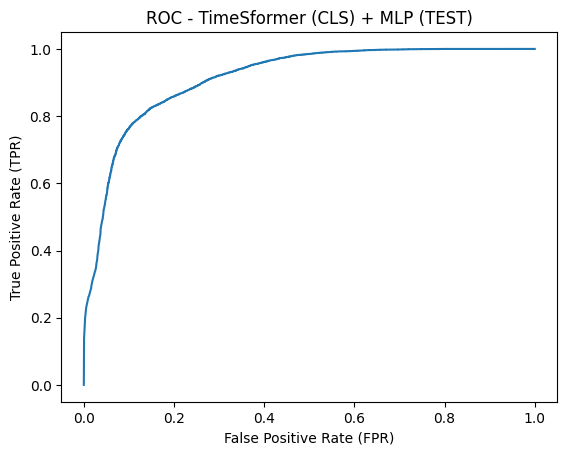

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_np, p_test_np)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC - TimeSformer (CLS) + MLP (TEST)")
plt.show()


## Paso 4 — Tabla resumen de desempeño (Validation vs Test) y guardado

### ¿Qué se hace en esta celda?
Se genera una tabla final con métricas de desempeño (val/test) y se guarda en CSV.

### Resultado esperado
- DataFrame `results_df`
- Archivo CSV exportado a `processed/`


In [10]:
from sklearn.metrics import accuracy_score

results_df = pd.DataFrame({
    "Split": ["Validation", "Test"],
    "AUC": [val_metrics["auc"], test_metrics["auc"]],
    "F1": [val_metrics["f1"], test_metrics["f1"]],
    "Recall": [val_metrics["recall"], test_metrics["recall"]],
    "FAR": [val_metrics["far"], test_metrics["far"]],
    "Accuracy": [
        accuracy_score(y_val_np, (p_val_np >= threshold).astype(int)),
        accuracy_score(y_test_np, (p_test_np >= threshold).astype(int)),
    ],
}).round(4)

print("\n=== Resultados de Desempeño: TimeSformer (CLS) + MLP ===\n")
display(results_df)

out_csv = PROCESSED / "results_performance_timesformer_mlp.csv"
results_df.to_csv(out_csv, index=False)
print("Guardado:", out_csv)



=== Resultados de Desempeño: TimeSformer (CLS) + MLP ===



,Split,AUC,F1,Recall,FAR,Accuracy
0,Validation,0.9538,0.8749,0.8738,0.1048,0.8854
1,Test,0.9138,0.8407,0.8507,0.1874,0.8324


Guardado: processed/results_performance_timesformer_mlp.csv


In [12]:
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

def uniform_sample_indices(start_f: int, end_f: int, T: int):
    n = max(1, end_f - start_f)
    idx = np.linspace(0, n - 1, T).round().astype(int)
    return (start_f + idx).astype(int)

class ClipDataset(Dataset):
    def __init__(self, df, T=8, img_size=224):
        self.df = df.reset_index(drop=True)
        self.T = T
        self.img_size = img_size
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["path"]
        start_f = int(row["start_frame"])
        end_f   = int(row["end_frame"])
        y = int(row["y"])

        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            raise RuntimeError(f"No pude abrir video: {path}")

        frame_ids = uniform_sample_indices(start_f, end_f, self.T)

        frames = []
        last_good = None
        for fid in frame_ids:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fid))
            ok, frame = cap.read()

            if not ok:
                frame = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8) if last_good is None else last_good
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (self.img_size, self.img_size), interpolation=cv2.INTER_LINEAR)
                last_good = frame

            frames.append(frame)

        cap.release()

        arr = np.stack(frames).astype(np.float32) / 255.0
        arr = (arr - self.mean) / self.std
        arr = np.transpose(arr, (3, 0, 1, 2))  # (C,T,H,W)
        clip = torch.from_numpy(arr)

        return clip, torch.tensor(y, dtype=torch.long)


## Paso 5 — Métricas operativas del encoder (latencia, ms/frame, FPS)

### ¿Qué se hace en esta celda?
Se mide el tiempo de inferencia del encoder TimeSformer sobre batches reales:
- warmup (no medir los primeros batches)
- medición promedio por batch
- latencia por clip
- ms/frame
- FPS efectivo

### Resultado esperado
- Impresión: avg s/batch, ms/clip, ms/frame, FPS


## Paso 6 — Time-To-Alert (TTA) estimado

### ¿Qué se hace en esta celda?
Se estima un **time-to-alert** aproximado como:
- duración temporal de la ventana (clip) = `T / fps_video`
- + latencia computacional (ms/clip)

### Resultado esperado
- Duración ventana
- Latencia computacional
- TTA estimado


In [ ]:
# =========================
# Paso 6 — Time-To-Alert (TTA) estimado
# =========================
# Requiere: T, time_per_clip (calculado en Paso 5)
video_fps = 30  # ajusta si tu fuente es distinta

latencia_clip_ms = time_per_clip * 1000.0
duracion_clip_s = T / video_fps
tta_s = duracion_clip_s + (latencia_clip_ms / 1000.0)

print("\n=== Paso 6: Time-To-Alert (TTA) ===")
print(f"FPS video asumido: {video_fps}")
print(f"Duración ventana (clip): {duracion_clip_s:.3f} s")
print(f"Latencia computacional: {latencia_clip_ms/1000:.3f} s")
print(f"Time-To-Alert estimado: {tta_s:.3f} s")


## Paso 7 — Complejidad computacional (FLOPs y parámetros)

### ¿Qué se hace en esta celda?
Se estima:
- GFLOPs del encoder
- número de parámetros

Usando `thop` sobre un tensor dummy con forma compatible.

### Resultado esperado
- GFLOPs
- Params (millones)


In [ ]:
# =========================
# Paso 7 — Complejidad computacional (GFLOPs y parámetros)
# =========================
# Requiere: encoder, DEVICE, T, IMG_SIZE
# Nota: el input dummy se arma en formato (B, T, C, H, W) para HF TimeSformer

from thop import profile
import torch

encoder.eval()

dummy = torch.randn(1, T, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)

# THOP usa inputs posicionales; para HF a veces requiere keyword.
# Si profile falla, usa el wrapper simple de abajo.
try:
    flops, params = profile(encoder, inputs=(dummy,), verbose=False)
except Exception:
    class EncoderWrapper(torch.nn.Module):
        def __init__(self, enc):
            super().__init__()
            self.enc = enc
        def forward(self, x):
            out = self.enc(pixel_values=x)
            # devolver algo tensorial para THOP (si devuelve objeto con last_hidden_state)
            if hasattr(out, "last_hidden_state"):
                return out.last_hidden_state
            if isinstance(out, (tuple, list)):
                return out[0]
            return out

    wrapped = EncoderWrapper(encoder).to(DEVICE)
    flops, params = profile(wrapped, inputs=(dummy,), verbose=False)

print("\n=== Paso 7: Complejidad Computacional ===")
print(f"FLOPs: {flops/1e9:.2f} GFLOPs")
print(f"Parámetros: {params/1e6:.2f} M")


## Paso 8 — Tabla final integrada (desempeño + operativas) y exportación

### ¿Qué se hace en esta celda?
Se arma una tabla única para reportar en tesis, combinando:
- desempeño (Test)
- métricas operativas (ms/frame, FPS, TTA)
- costo computacional (GFLOPs)

### Resultado esperado
- DataFrame `final_table`
- CSV exportado


In [ ]:
# =========================
# Paso 8 — Tabla final integrada (desempeño + operativas) y exportación
# =========================
# Requiere: test_metrics, acc_test, tn, fp, fn, tp, flops, params, tta_s,
#           time_per_frame, fps_effective, y objeto Path/dir PROCESSED (o usa string)

import pandas as pd
from pathlib import Path

# Ajusta esta ruta si tu proyecto usa otra variable (PROCESSED_DIR, etc.)
PROCESSED = Path("processed")

final_table = pd.DataFrame({
    "Modelo": ["TimeSformer + MLP"],
    "AUC (Test)": [round(test_metrics["auc"], 4)],
    "F1 (Test)": [round(test_metrics["f1"], 4)],
    "Recall (Test)": [round(test_metrics["recall"], 4)],
    "FAR (Test)": [round(test_metrics["far"], 4)],
    "Accuracy (Test)": [round(float(acc_test), 4)],
    "TN": [int(tn)], "FP": [int(fp)], "FN": [int(fn)], "TP": [int(tp)],
    "ms/frame": [round(time_per_frame * 1000.0, 2)],
    "FPS": [round(float(fps_effective), 2)],
    "TTA (s)": [round(float(tta_s), 3)],
    "GFLOPs": [round(float(flops/1e9), 2)],
    "Params (M)": [round(float(params/1e6), 2)],
})

display(final_table)

out_csv = PROCESSED / "final_report_timesformer_full.csv"
final_table.to_csv(out_csv, index=False)
print("Guardado:", out_csv)
